<a href="https://colab.research.google.com/github/bdekoz/midnight.sfo-2025-02.1/blob/main/lcp_perf_analysis_2025q1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Performance analysis concentrating on understanding the current state of the Largest Contentful Paint (LCP) metric, and how it correlates and compares to existing NavigationTiming and Visual metrics.

Experimental data was collected between (2025-02-07, 11), on a wireless connection in SFO/149 NMG room 546. The Chrome () and Firefox browsers (nightly as of 20250204) were hosted on Android 15, the browsertime testing framework was used in combination with [sitelists generated](https://github.com/bdekoz/mozilla-data-sitelists/blob/main/docs/sitelist_generation.md) from CrUX.

Two devices were used: a rooted Pixel 8 (shiba), and a rooted Google Tablet (tangor). Setup [details](https://sunglint.wordpress.com/2024/05/22/android-2024-devices/)

[github repo 1](https://github.com/bdekoz/midnight.sfo-2025-02.1)

[github repo 2](https://github.com/bdekoz/midnight.sfo-2025-02.2)



In [ ]:
#@title setup, static and constant data
import json
import os
import requests

from google.cloud import bigquery
from datetime import datetime, timedelta
from re import sub
from os import path
from google.colab import auth
auth.authenticate_user()

# Mount Google Drive
from google.colab import drive
gdrive = '/content/drive/'
gdriveprefix = gdrive + 'My Drive/Colab Notebooks/'
drive.mount(gdrive, force_remount=True)

# use interactive tables
from google.colab import data_table
data_table.enable_dataframe_formatter()


import datetime
import time
import hashlib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
from scipy.stats import ttest_ind
from scipy.stats import ks_2samp
from scipy.stats import mannwhitneyu

pd.set_option('display.width', 1920)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

# useful constants
tab = "\t";
newline = "\n";



# data file locations
# 2.1 is baseline tp6m
# 2.2 is baseline tp6m with a11y on
data1_file ='https://raw.githubusercontent.com/bdekoz/midnight.sfo-2025-02.1/main/results/2025-02-11/data.json'
data2_file ='https://raw.githubusercontent.com/bdekoz/midnight.sfo-2025-02.2/main/results/2025-02-13/data.json'




Mounted at /content/drive/


In [ ]:
#@title percentage(numerator, denom) / percentage_change(one, two) / deserialize_csv(csvfile)

def percentage(part, whole):
  Percentage = 100 * float(part)/float(whole)
  return str(int(round(Percentage,0))) + '%'

def percentage_change(col1, col2):
  return (((col2 - col1) / col1) * 100)


def deserialize_csv(csvfile):
    # null values as empty string
    # df = pd.read_csv(csvfile, sep='|', keep_default_na=False);
    # null values as 0.0
    df = pd.read_csv(csvfile, sep='|').fillna(value = 0.0);
    df.set_index(df.columns[0]) #set the first column as the index
    df_len = len(df.index);
    #print("dataframe rows: " + str(df_len));
    return df;



In [ ]:
#@title deserialize_json(jfile) / deserialize_json_metrics_by_browser / content_traits_active_count / content_traits_active_p / deserialize_json_metrics_by_browser_if

# simple, all pandas
def deserialize_json(jfile):
    # null values as empty string
    # df = pd.read_csv(csvfile, sep='|', keep_default_na=False);
    # null values as 0.0
    df = pd.read_json(jfile)
    df.set_index('test') #set the json field 'test' as the index
    df_len = len(df.index);
    #print("dataframe rows: " + str(df_len));
    return df;


# Assume jfile is a json file that is an aggregate of pageload data
# collected from a set of URLS, matching existing midnight schema.
def deserialize_json_metrics_by_browser(jfile, browser):
    # 1 local file
    #with open(jfile, "r") as file:
    #  data = json.load(file)

    # 2 github repo URL
    response = requests.get(jfile)
    data = response.json()

    # either walk json and add it here or flatten json with json_normalize
    metric_data = {}
    for item in data:
      test_data = {}
      url_mini = item['test']

      metrics_array = item[browser]['metrics']
      lcpe_data = metrics_array['lcp_element']

      # Only extract metrics with 'median' fields from the JSON
      metric_only = {key: value["median"] for key, value in metrics_array.items() if isinstance(value, dict) and "median" in value}
      test_data.update(metric_only)
      # Add lcp element
      test_data['lcp_element'] = lcpe_data

      metric_data[url_mini] = test_data

    df = pd.DataFrame(metric_data)
    df = df.transpose()
    df = df.rename(columns={"largestContentfulPaintloadTime": "lcp_load", "largestContentfulPaintrenderTime": "lcp_render"})
    #df.columns.values[0] = "url_mini"
    #df.set_index('test') #set the json field test as the index
    df_len = len(df.index);
    print("dataframe rows: " + str(df_len));
    return df;


# Number of fields of the url_content_traits object that have a non-zero value.
def content_traits_active_count(data):
  count = 0
  for key, value in data.items():
      if value != 0:
        count += 1
  return count;

  # Number of fields of the url_content_traits object that have a non-zero value.
def content_traits_active_p(data, trait):
  b = data[trait] != 0;
  return b;


# Assume jfile is a json file that is an aggregate of pageload data
# collected from a set of URLS, matching existing midnight schema.
def deserialize_json_metrics_by_browser_if(jfile, browser, trait):
    # 1 local file
    #with open(jfile, "r") as file:
    #  data = json.load(file)

    # 2 github repo URL
    response = requests.get(jfile)
    data = response.json()

    # either walk json and add it here or flatten json with json_normalize
    metric_data = {}
    for item in data:
      test_data = {}
      url_mini = item['test']
      traits_dict = item['url_content_traits']

      if not content_traits_active_p(traits_dict, trait):
        continue

      metrics_array = item[browser]['metrics']
      lcpe_data = metrics_array['lcp_element']

      # Only extract metrics with 'median' fields from the JSON
      metric_only = {key: value["median"] for key, value in metrics_array.items() if isinstance(value, dict) and "median" in value}
      test_data.update(metric_only)
      # Add lcp element
      test_data['lcp_element'] = lcpe_data

      metric_data[url_mini] = test_data

    df = pd.DataFrame(metric_data)
    df = df.transpose()
    df = df.rename(columns={"largestContentfulPaintloadTime": "lcp_load", "largestContentfulPaintrenderTime": "lcp_render"})
    #df.columns.values[0] = "url_mini"
    #df.set_index('test') #set the json field test as the index
    df_len = len(df.index);
    print("dataframe rows: " + str(df_len));
    return df;


In [ ]:
#@title compare_2_lcp_elements / compare_4_lcp_elements / compare_2_lcp_values

# Compare two data frames for LCP element matching
def compare_2_lcp_elements(df1, df2):

  # error check data frame sizes, which should match
  if len(df1.index) != len(df2.index):
    print("Exiting, dataframes have different indexes");
  dflen = len(df1.index);

  #dfbool = df2.columns[lcp-element] != df1.columns[lcp-element];
  dflcpe = df2["lcp_element"] == df1["lcp_element"];
  lcpe_same = dflcpe.sum();
  lcpmatch = percentage(lcpe_same, dflen);
  return lcpmatch;


# Compare four data frames for LCP element matching
def compare_4_lcp_elements(df1, df2, df3, df4):
  # error check input data frames
  if len(df1.index) != len(df2.index) != len(df3.index) != len(df4.index):
    print("Exiting, dataframes have different indexes");
  dflen = len(df1.index);

  dflcpe1 = df1["lcp_element"] == df2["lcp_element"];
  dflcpe2 = df3["lcp_element"] == df4["lcp_element"];
  dflcpe = dflcpe1 & dflcpe2;
  lcpe_same = dflcpe.sum();

  lcpmatch = percentage(lcpe_same, dflen);
  return lcpmatch;


# Compare two data frames (with LCP element matching) for LCPrender times
def compare_2_lcp_values(df1, df2):
  df1_lcpr = pd.to_numeric(df1["lcp_render"], errors='coerce') # Convert to numeric, handle errors
  df2_lcpr = pd.to_numeric(df2["lcp_render"], errors='coerce') # Convert to numeric, handle errors

  #print(df1_lcpr.head(10))
  print("firefox lcp render min/max/median");
  print(df1_lcpr.min())
  print(df1_lcpr.max())
  print(df1_lcpr.median())
  print("\n")

  #print(df2_lcpr.head(10))
  print("chrome lcp render min/max/median");
  print(df2_lcpr.min())
  print(df2_lcpr.max())
  print(df2_lcpr.median())
  print("\n")

  #dfpchange = percentage_change(df1["lcp-render"], df2["lcp-render"])
  dfpchange = percentage_change(df1_lcpr, df2_lcpr)
  dfpchangesort = dfpchange.sort_values(ascending=False)
  #print("firefox/chrome % change: \n" + str(dfpchange));
  print("firefox/chrome % change: \n" + str(dfpchangesort));
  print("\n")

  #print(dfpchange.head(10))
  print("min/max/median");
  print(dfpchange.min())
  print(dfpchange.max())
  print(dfpchange.median())
  print("\n")

  #print(dfpchange);
  dfpchange.plot();

In [ ]:
#@title correlate_lcp_to_metrics


def correlate_lcp_to_metrics(df):
  #filter data frame to no non-null lcp-render value rows
  #df1_lcpr = df1[df1["lcp-render"].notnull()]


  df_lcpr = df["lcp_render"]

  #print("first ten values");
  #print(df1_lcpr.head(10)) # print 10 rows
  #print("\n");
  #df1_lcpr.plot()
  #print("\n");

  corrsic = df_lcpr.corr(df['fetchStart'], method='pearson');
  print("fetchStart " + str(corrsic))

  corrsic = df_lcpr.corr(df['responseStart'], method='pearson');
  print("responseStart " + str(corrsic))

  corrsic = df_lcpr.corr(df['domComplete'], method='pearson');
  print("domComplete " + str(corrsic))
  print("\n");


  # Correlation between all relevant columns of DataFrame (except 1,2,5,6 below)
  # url-id, url, fetchStart, connectStart, responseStart, SpeedIndex, VC85, fcp, lcp-load, lcp-render, lcp-element
  # url_id|url|power|redirectEnd|fetchStart|domainLookupStart|connectStart|requestStart|responseStart|domContentLoadedEventStart|domComplete|SpeedIndex|VC85|fcp|lcp_load|lcp_render|lcp_element
  df1e = df.iloc[:, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]];
  #print(df1e.head(10));
  corre = df1e.corr();
  print(corre);

  #df1e_lcpr = df1e["lcp_render"];
  #corre = df1e_lcpr.corr(df1e, method='pearson');
  #print(corre)
  #print(df1);


# LCP Analysis 2 Browsers


In [ ]:
#df1 = deserialize_json(data1_file)
#print(df1)

print("firefox")
dffx = deserialize_json_metrics_by_browser(data1_file, "firefox")
print(dffx)

print(newline)

print("chrome")
dfchr = deserialize_json_metrics_by_browser(data1_file, "chrome")
print(dfchr)

firefox
dataframe rows: 23
                                     fcp lcp_load lcp_render redirectStart redirectEnd fetchStart domainLookupStart connectStart requestStart responseStart domInteractive domComplete loadEventEnd SpeedIndex VisualComplete85 LastVisualChange                                                                                                                                                                                                                            lcp_element
allrecipes                           392      645        686             0           0         -2              36.5         43.5           84           237            456         494          500       2031             2848             8585                                       ""https://www.allrecipes.com/thmb/HoUlJ4uVESFamOu0fw_fGe1aiJk=/400x250/filters:no_upscale():max_bytes(150000):strip_icc()/1189502_Baked-Shrimp-Scampi-4x3-e9e6b5daa65b4635985fd701999b8de3.jpg""
amazon                       

#LCP Element match 2 browsers

In [ ]:
cmp_pre = compare_2_lcp_elements(dffx, dfchr);
print("ff/chrome lcp match: " + cmp_pre);



ff/chrome lcp match: 39%


#LCP Correlations with other metrics

# create bool array for all results where LCP elements match.
dflcpeqp = df2["lcp_element"] == df1["lcp_element"];
print("df1 len: " + str(len(df1.index)));
print("df2 len: " + str(len(df2.index)));
print("fenix/chrome lcp matching set length: " + str(len(dflcpeqp.index)));

#firefox correlations with other metrics

In [ ]:
correlate_lcp_to_metrics(dffx)



fetchStart 0.2344877535099974
responseStart 0.43926550686149823
domComplete 0.49112663860287803


                        fcp  lcp_load  lcp_render  redirectStart  redirectEnd  fetchStart  domainLookupStart  connectStart  requestStart  responseStart  domInteractive  domComplete  loadEventEnd  SpeedIndex  VisualComplete85  LastVisualChange
fcp                1.000000  0.452320    0.477224       0.102455    -0.119104    0.533382           0.539049      0.588296      0.636674       0.648521        0.786106     0.779098      0.776986    0.703120          0.766234          0.559916
lcp_load           0.452320  1.000000    0.917780       0.011807    -0.302840    0.202311           0.212301      0.267651      0.257969       0.407547        0.469435     0.471700      0.472093    0.695074          0.576982          0.397112
lcp_render         0.477224  0.917780    1.000000       0.043694    -0.198993    0.234488           0.245301      0.301872      0.321745       0.439266        0.489083     0

#chrome correlations with other metrics

In [ ]:
correlate_lcp_to_metrics(dfchr)

fetchStart 0.8200205412629201
responseStart 0.8658803917067145
domComplete 0.7545775449886573


                        fcp  lcp_load  lcp_render  redirectStart  redirectEnd  fetchStart  domainLookupStart  connectStart  requestStart  responseStart  domInteractive  domComplete  loadEventEnd  SpeedIndex  VisualComplete85  LastVisualChange
fcp                1.000000 -0.038664    0.880534      -0.176603    -0.175277    0.806332           0.795279      0.815929      0.834955       0.863426        0.892231     0.759014      0.757764    0.473290          0.494076          0.590484
lcp_load          -0.038664  1.000000    0.135672      -0.134904    -0.112764   -0.263161          -0.262205     -0.258220     -0.259135      -0.134429       -0.053784     0.116741      0.117800    0.125840         -0.040929          0.174011
lcp_render         0.880534  0.135672    1.000000      -0.187049    -0.188385    0.820021           0.791350      0.809501      0.831442       0.865880        0.886070     0.7

# LCP Render compare 2 browsers

firefox lcp render min/max/median
532
3030
1200.0


chrome lcp render min/max/median
462
6814
1440.0


firefox/chrome % change: 
google_restaurants_near_me            180.058224
sina                                  124.884488
espn_the_comparison                   117.794254
m_ebay_kleinanzeigen_de                85.088293
m_ebay_kleinanzeigen_de_c199_l3331     83.827807
bild_de_super_bowl                     63.542340
dailymail_co_uk_experts_say            42.279412
bing_restaurants_in_exton_pa_19341     32.311622
amazon_mobile_phone                    23.157895
booking                                19.527825
m_imdb                                 18.406072
youtube_COU5T_Wafa4                    16.878049
support_microsoft_en_us                13.876967
google_pwa                             12.568306
m_youtube                              12.198582
cnn_why_hurricane                       4.046243
allrecipes                              0.874636
m_facebook                            

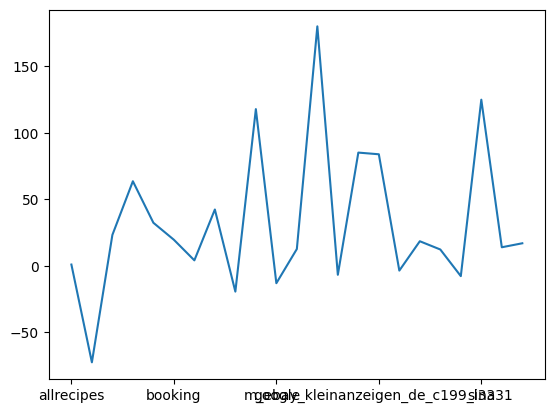

In [ ]:
compare_2_lcp_values(dffx, dfchr)

# LCP Render compare 2 browsers same element only

df1 len: 23
df2 len: 23
fenix/chrome lcp matching set length: 23
firefox lcp match length: 9
chrome lcp match length: 9
firefox lcp render min/max/median
544
2965
1079.0


chrome lcp render min/max/median
774
3544
1440.0


firefox/chrome % change: 
espn_the_comparison            117.794254
bild_de_super_bowl              63.542340
dailymail_co_uk_experts_say     42.279412
amazon_mobile_phone             23.157895
booking                         19.527825
m_imdb                          18.406072
youtube_COU5T_Wafa4             16.878049
support_microsoft_en_us         13.876967
cnn_why_hurricane                4.046243
Name: lcp_render, dtype: float64


min/max/median
4.046242774566474
117.79425393883226
19.527824620573355




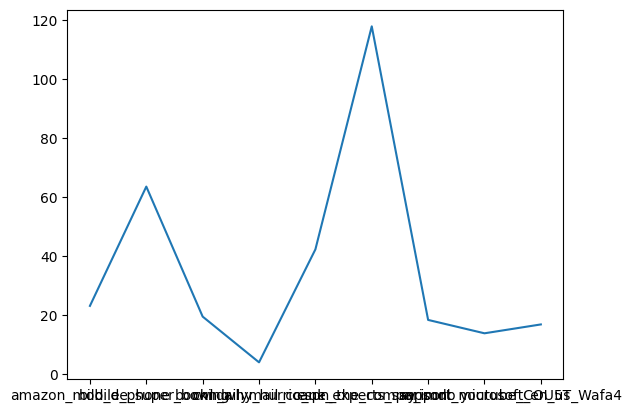

In [ ]:
# create bool array for all results where LCP elements match.
dffx, dfchr
dflcpeqp = dffx["lcp_element"] == dfchr["lcp_element"];
print("df1 len: " + str(len(dffx.index)));
print("df2 len: " + str(len(dfchr.index)));
print("fenix/chrome lcp matching set length: " + str(len(dflcpeqp.index)));


# filter results for only matching LCP elements.
df1_setas1 = dffx[dflcpeqp];
print("firefox lcp match length: " + str(len(df1_setas1.index)));


df2_setas1 = dfchr[dflcpeqp];
print("chrome lcp match length: " + str(len(df2_setas1.index)));


compare_2_lcp_values(df1_setas1, df2_setas1)







# Priority Hints Analysis
